Remaining NaNs: 0
Accuracy: 0.8154506437768241
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       117
           1       0.87      0.74      0.80       116

    accuracy                           0.82       233
   macro avg       0.82      0.82      0.81       233
weighted avg       0.82      0.82      0.81       233



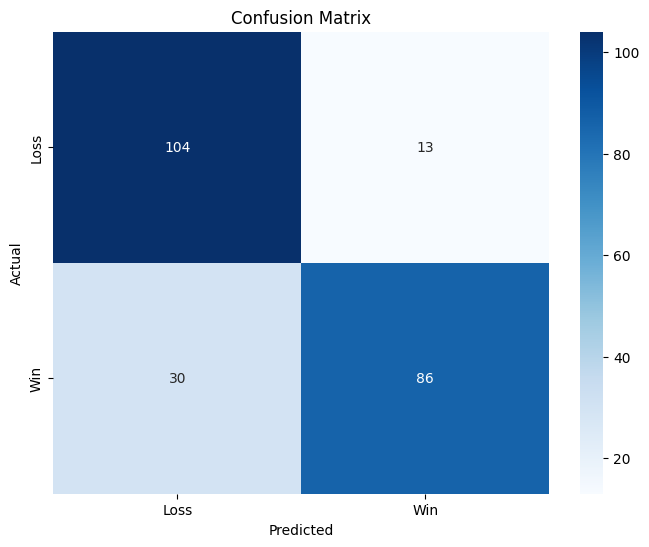

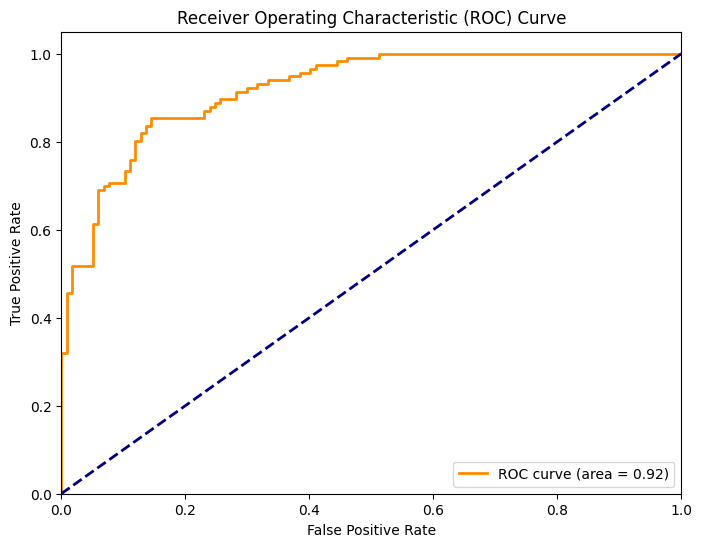


Note: Feature importance visualization is most meaningful for linear kernels.


<Figure size 800x600 with 0 Axes>

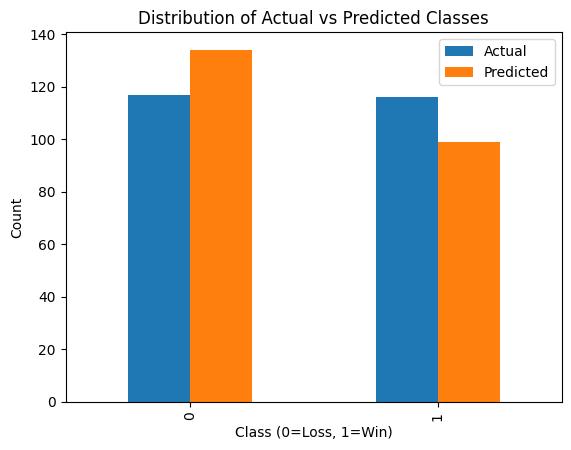

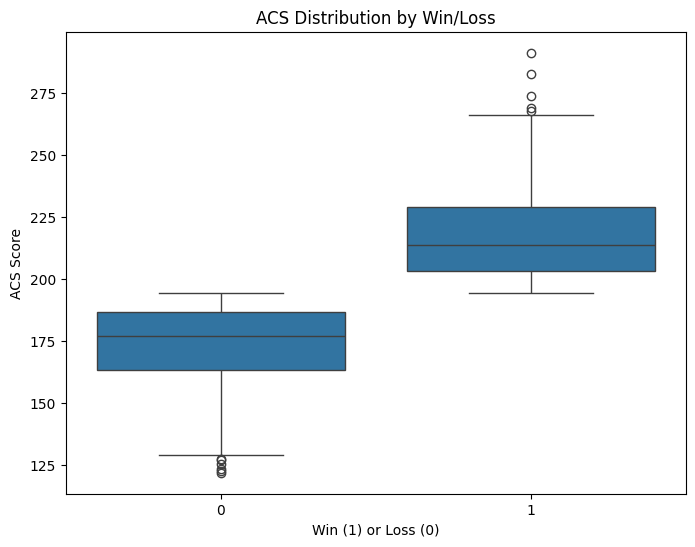

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Load data
data = pd.read_csv('VCT_2024.csv')

# Drop irrelevant columns
drop_cols = ['Region', 'Player', 'Team Abbreviated', 'Event', 'CL', 'R']
data = data.drop(columns=drop_cols)

# Define numeric columns (including ACS)
numeric_cols = ['ACS', 'K:D', 'KAST', 'ADR', 'KPR', 'APR', 'FKPR', 'FDPR', 'HS%', 'CL%', 'CW', 'CP']

# Define Binary Target (Win=1, Loss=0)
data['Win'] = (data['ACS'] >= data['ACS'].median()).astype(int)
y = data['Win']
X = data.drop(columns=['Win'])

# Preprocessing
# 1. Encode categorical variables (Team)
X = pd.get_dummies(X, columns=['Team'], drop_first=True)

# 2. Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X[numeric_cols] = imputer.fit_transform(X[numeric_cols])

# 3. Normalize numeric features
scaler = MinMaxScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# 4. Final check for NaNs
print("Remaining NaNs:", X.isna().sum().sum())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train SVM
svm_pipeline = make_pipeline(
    SVC(kernel='rbf', C=1.0, probability=True)
)
svm_pipeline.fit(X_train, y_train)

# Evaluate
y_pred = svm_pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ===== Visualization Section =====

# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Loss', 'Win'], 
            yticklabels=['Loss', 'Win'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 2. ROC Curve (only works with probability=True in SVC)
plt.figure(figsize=(8, 6))
y_prob = svm_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 3. Feature Importance (for SVM with linear kernel)
# Note: For RBF kernel, feature importance isn't straightforward
# This is just an approximation for visualization
if svm_pipeline.named_steps['svc'].kernel == 'linear':
    plt.figure(figsize=(10, 6))
    coef = svm_pipeline.named_steps['svc'].coef_[0]
    features = X.columns
    importance = pd.Series(coef, index=features).sort_values()
    importance.plot(kind='barh')
    plt.title('Feature Importance (SVM Coefficients)')
    plt.show()
else:
    print("\nNote: Feature importance visualization is most meaningful for linear kernels.")

# 4. Distribution of Predictions vs Actual
plt.figure(figsize=(8, 6))
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).apply(pd.Series.value_counts).plot(kind='bar')
plt.title('Distribution of Actual vs Predicted Classes')
plt.xlabel('Class (0=Loss, 1=Win)')
plt.ylabel('Count')
plt.legend(['Actual', 'Predicted'])
plt.show()

# 5. ACS Distribution by Win/Loss (original target)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Win', y='ACS', data=data)
plt.title('ACS Distribution by Win/Loss')
plt.xlabel('Win (1) or Loss (0)')
plt.ylabel('ACS Score')
plt.show()